In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pickle

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Data visualization
import cufflinks as cf
cf.set_config_file(theme="white", offline=True)

## Class

In [2]:
from pandas import DataFrame
class FeatureEngineering():
    
    def __init__(self,df):
        self.df= df
        self.temp= DataFrame()
        
    def createLags(self,column):
        temp= self.df[[column]]
        for i in range(1,34):
            temp[column+"_"+str(i)] = temp[column].shift(i)
        self.temp=temp
    
    def smoothing(self, column):
        for i in range(2,10,1):
            j=i/10
            fit1 = SimpleExpSmoothing(self.temp[column], initialization_method="heuristic").fit(smoothing_level=j, optimized=False)
            lista=fit1.fittedvalues
            self.temp['exp'+str(j)]=lista
            
    def createMA(self,column):
        for i in range(2,11,2):
            self.temp["MA"+str(i)]= self.temp[column].rolling(window =i).mean()
    
   
    
    def createVariables(self,column):
        self.createLags(column)
        #self.smoothing(column)
        self.createMA(column)
        self.temp["Target"]= self.temp[column].shift(-1)
        self.temp.dropna(inplace=True)
        return self.temp

### Load data

In [4]:
df_cubo= pd.read_csv("cubo_sem.csv")

In [5]:
df_cubo.rename(columns={'week':"date"}, inplace=True)
df_cubo.set_index('date', inplace=True)

## Create features

In [6]:
dc={}
ls_df=[]
for zone in range(5):
    for crime in range(100,105):
        feature= FeatureEngineering(df_cubo)
        column= "Crimes_Z"+str(zone)+"T"+str(crime)
        dc[column]= feature.createVariables(column).reset_index()
        ls_df.append(dc[column])

## Create models

In [9]:
from datetime import datetime,timedelta
from pandas import date_range,concat,DataFrame
from pickle import load
from numpy import ceil

class predicter():
    def __init__(self,data):
        self.start=(pd.to_datetime(df["date"].max()) + timedelta(days=1)).strftime('%Y-%m-%d')
        self.df= data.copy()

        
    def loadScaler(self,column):
        zone=column[8]
        crime=column[10:]
        scx_file="NewModels/sc_x_"+crime+"_"+zone+".pkl"
        scy_file="NewModels/sc_y_"+crime+"_"+zone+".pkl"
        with open(scx_file, "rb") as fp:
            sc= load(fp)
        with open(scy_file, "rb") as fp:
            sc2= load(fp)
        self.sc= sc
        self.sc2= sc2
        
    def loadModel(self,column):
        zone=column[8]
        crime=column[10:]
        with open("NewModels/XGBoost/modeloSem_"+zone+"_"+crime+".pkl", "rb") as m:
            model = load(m)
        self.model= model
        
    def scalerData(self,column,row):
        X,y=self.df.drop(["Target",'date'],axis=1).iloc[row,:].to_numpy(),self.df[["Target"]].iloc[row,:].to_numpy()

        X=self.sc.transform(X.reshape(1,-1))
        y=self.sc2.transform(y.reshape(-1,1))
        X= X.reshape(-1,X.shape[1])
        #X= X.reshape(X.shape[0], 1, X.shape[1])
        return X, y
    
    def forecast(self,X):
        self.tomorrow= ceil(self.sc2.inverse_transform((self.model.predict(X)).reshape(-1,1)))[0][0]
    
    def generateRow(column):
        zone=column[8]
        crime=column[10:]
        ls= [(self.start,zone,crime, self.tomorrow)]
        return DataFrame(columns=["date", "zone","crime","prediction"],data=ls )

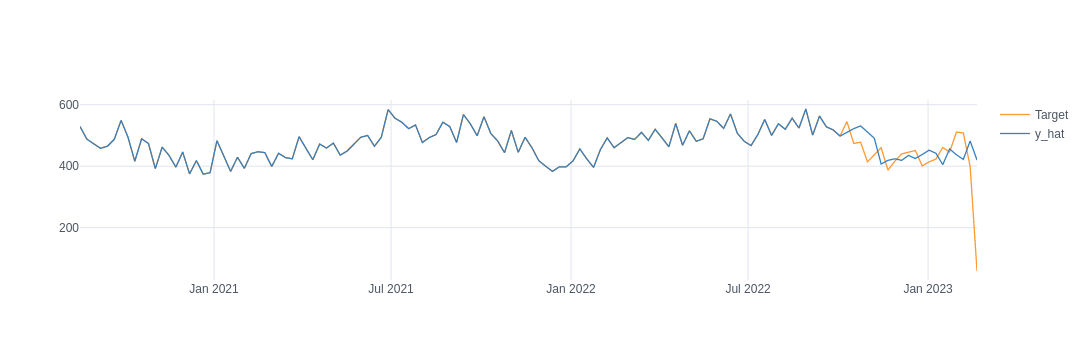

RMSE zone 0 delito 100: 95.06576218887596


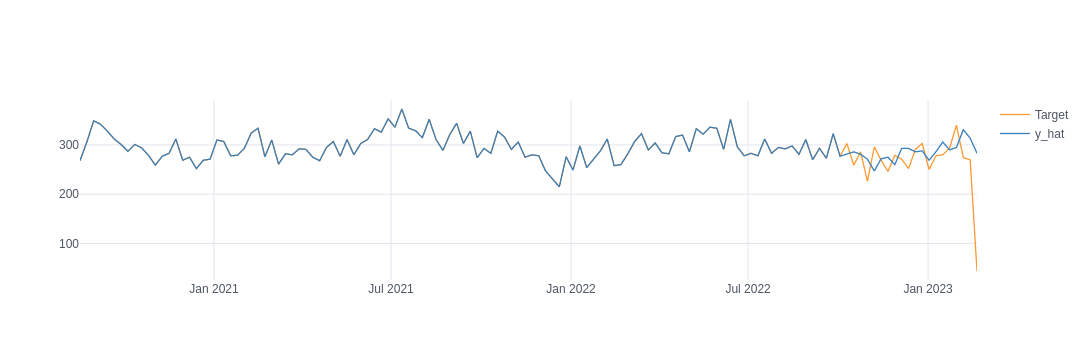

RMSE zone 0 delito 101: 61.116702945532836


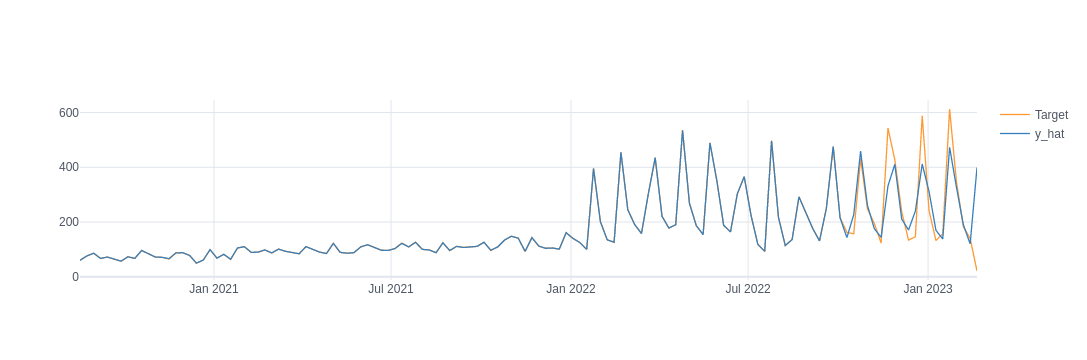

RMSE zone 0 delito 102: 114.88363534991818


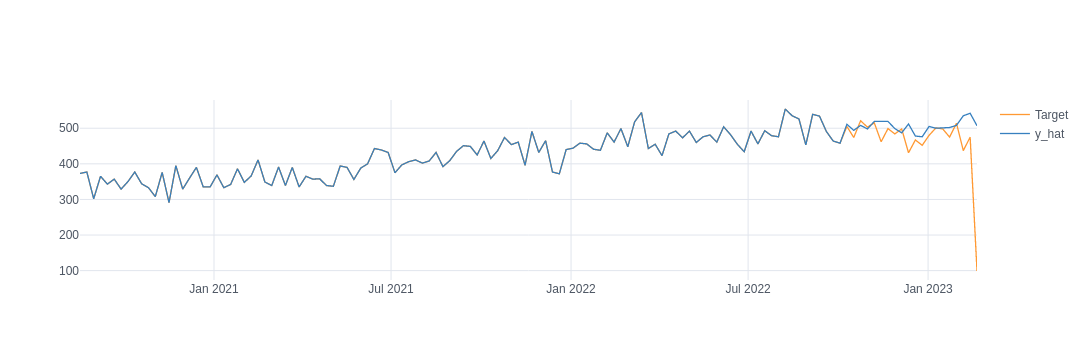

RMSE zone 0 delito 103: 98.40102854048176


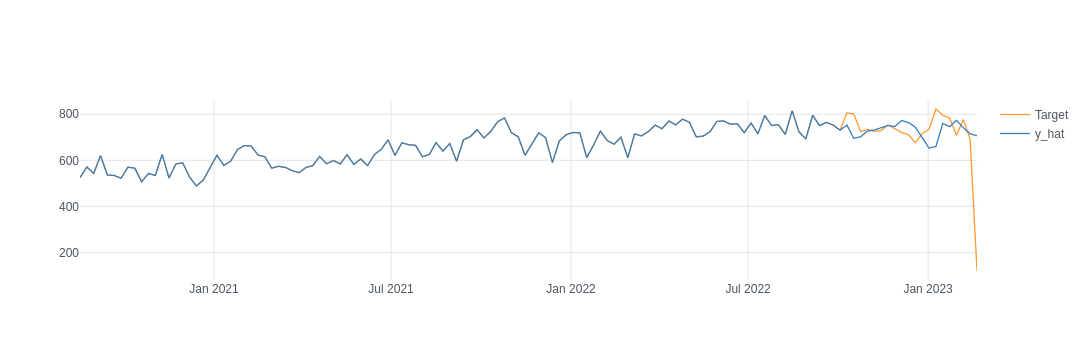

RMSE zone 0 delito 104: 143.70078771863433


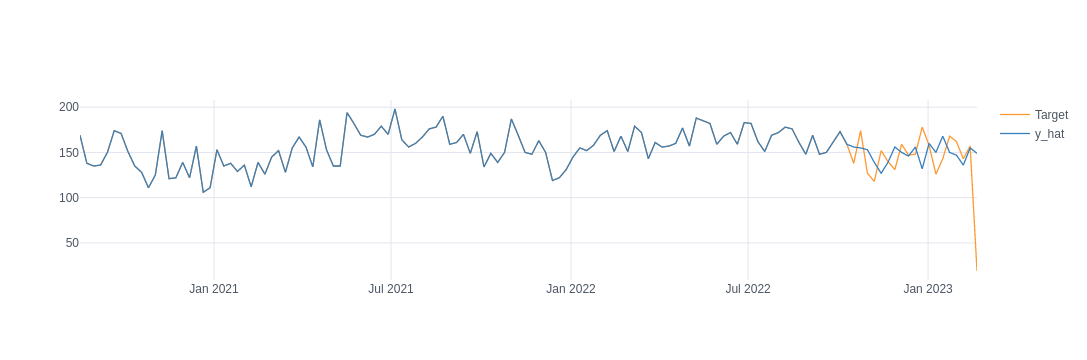

RMSE zone 1 delito 100: 34.65512931971899


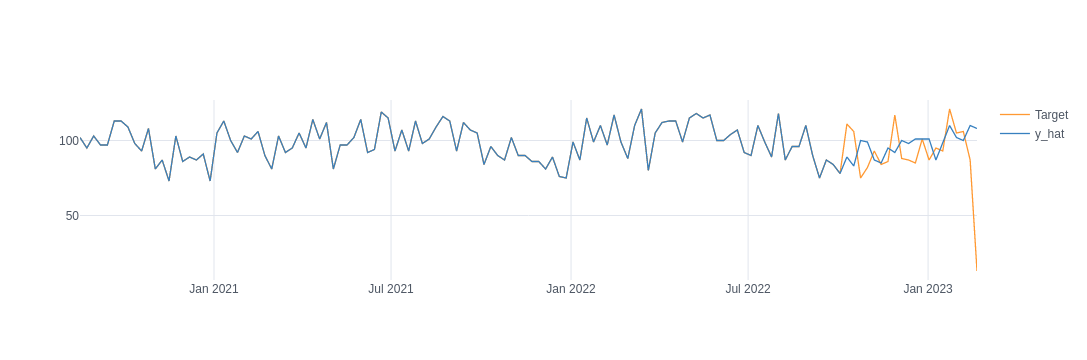

RMSE zone 1 delito 101: 25.855987161687388


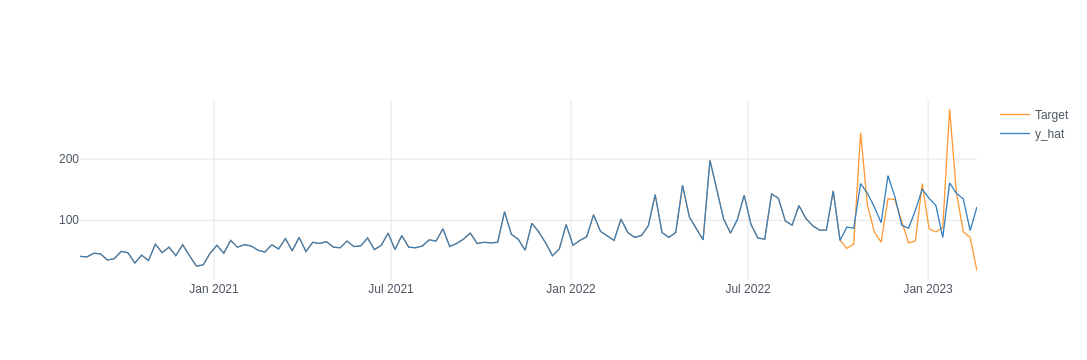

RMSE zone 1 delito 102: 49.87923592836493


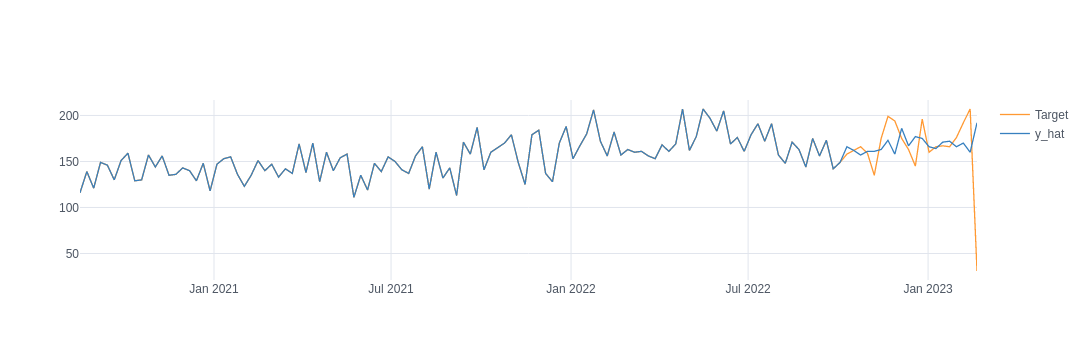

RMSE zone 1 delito 103: 40.87212479040734


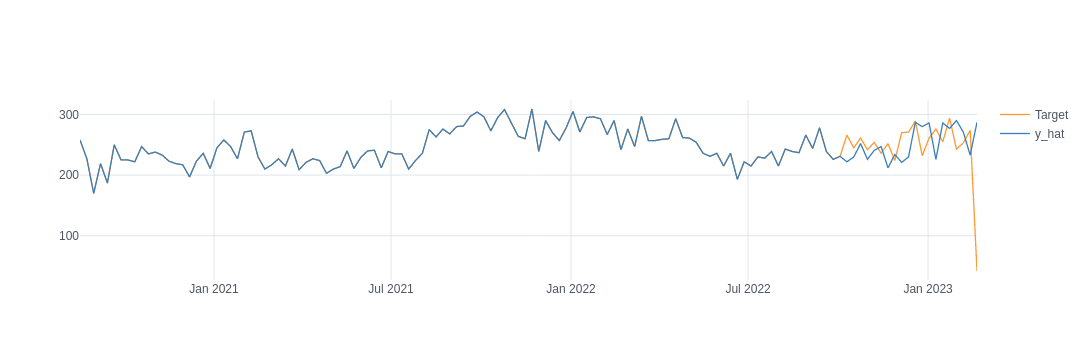

RMSE zone 1 delito 104: 63.01851839159104


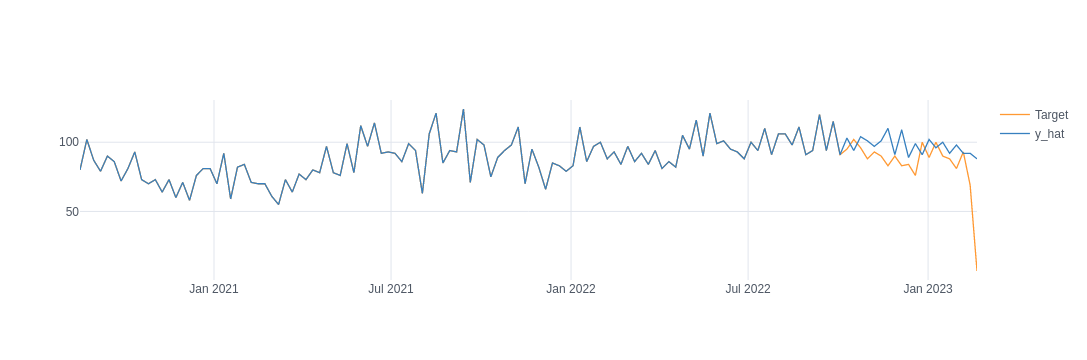

RMSE zone 2 delito 100: 22.68726793156519


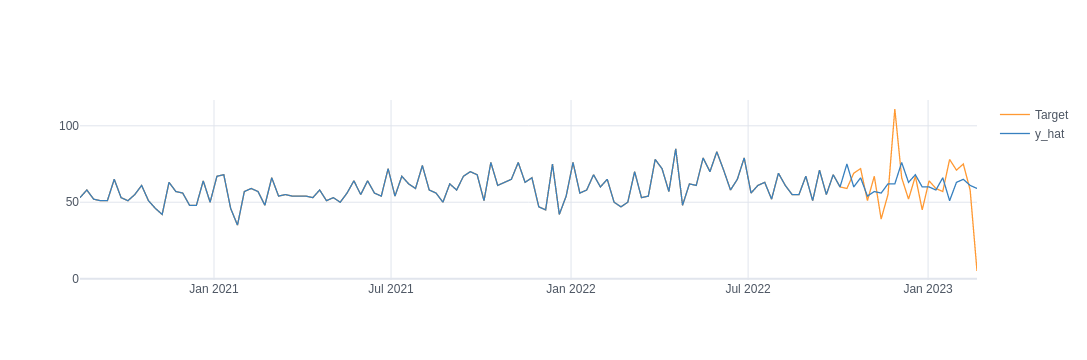

RMSE zone 2 delito 101: 19.517391532094813


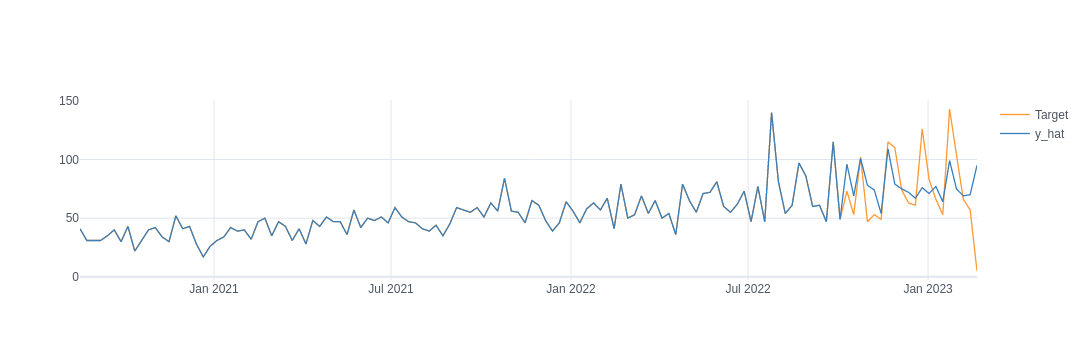

RMSE zone 2 delito 102: 29.459863506292965


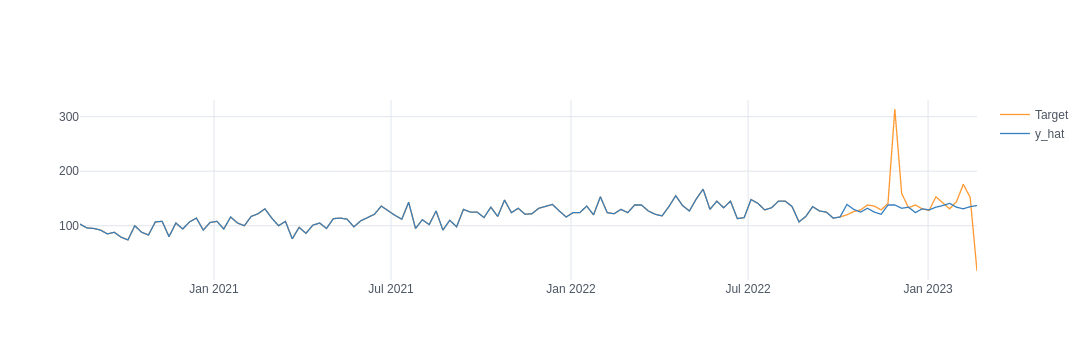

RMSE zone 2 delito 103: 49.95691146547331


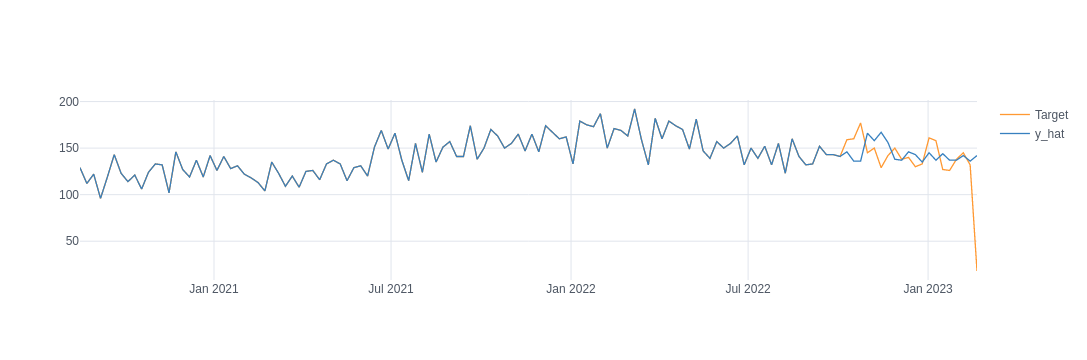

RMSE zone 2 delito 104: 32.68562780440342


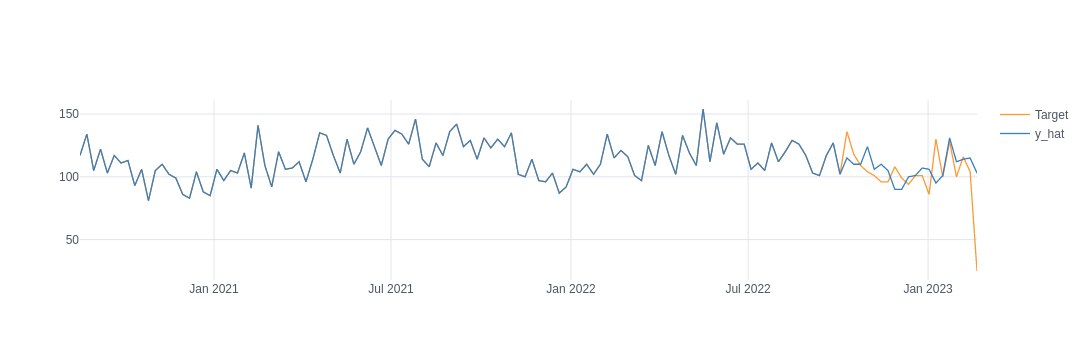

RMSE zone 3 delito 100: 21.957630043857353


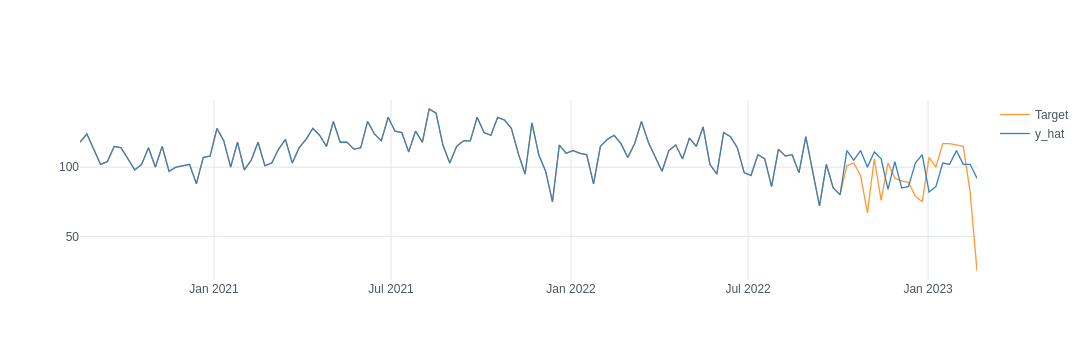

RMSE zone 3 delito 101: 23.4848522672175


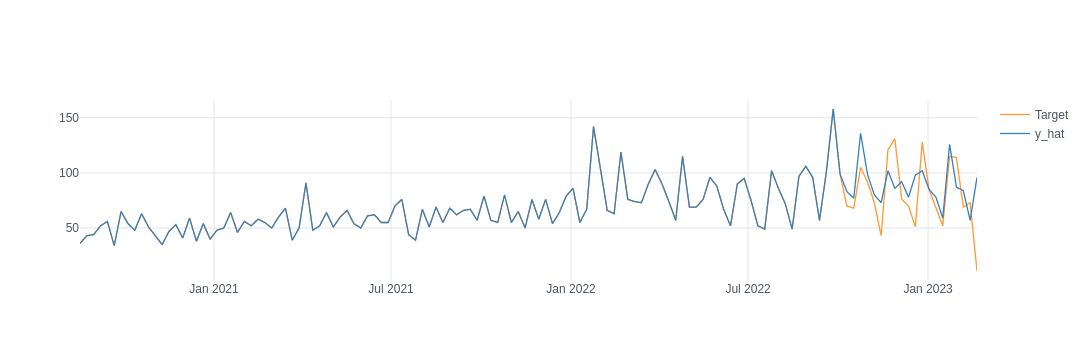

RMSE zone 3 delito 102: 28.78429404058601


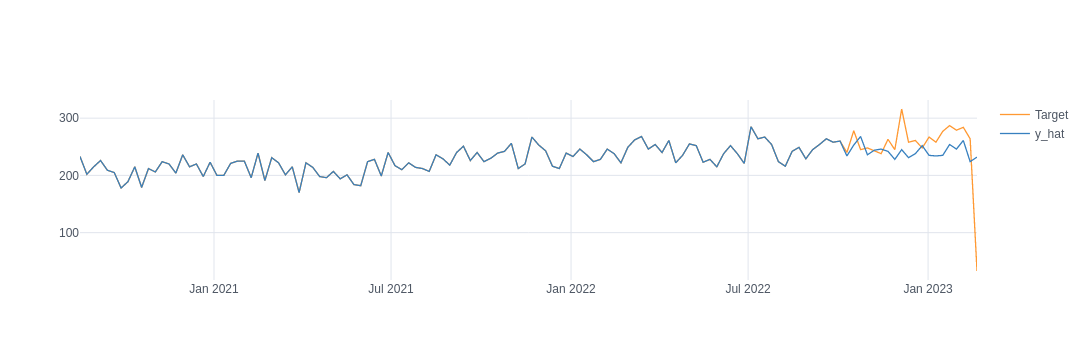

RMSE zone 3 delito 103: 52.6930172647662


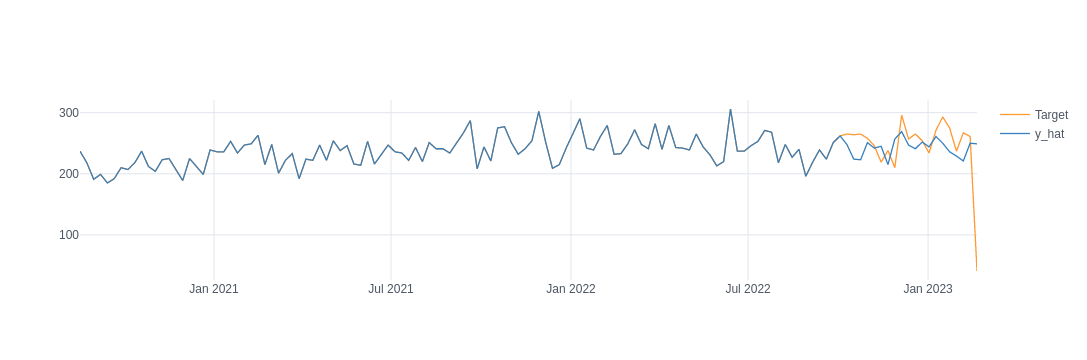

RMSE zone 3 delito 104: 53.688291758899


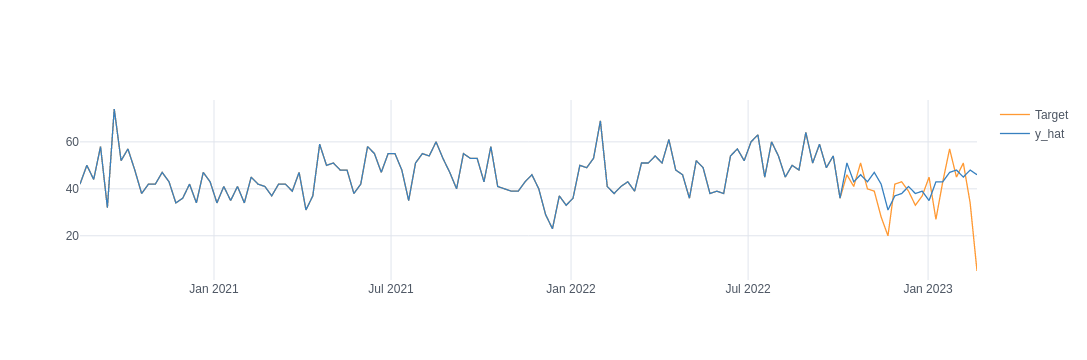

RMSE zone 4 delito 100: 12.061937103903926


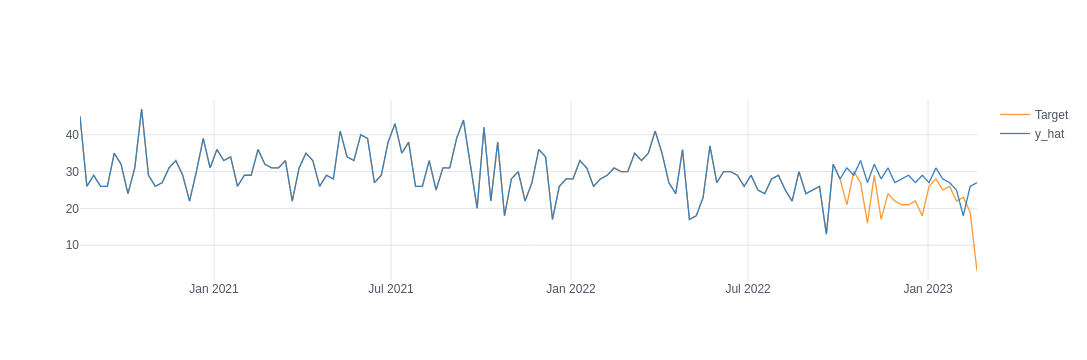

RMSE zone 4 delito 101: 8.308785528241737


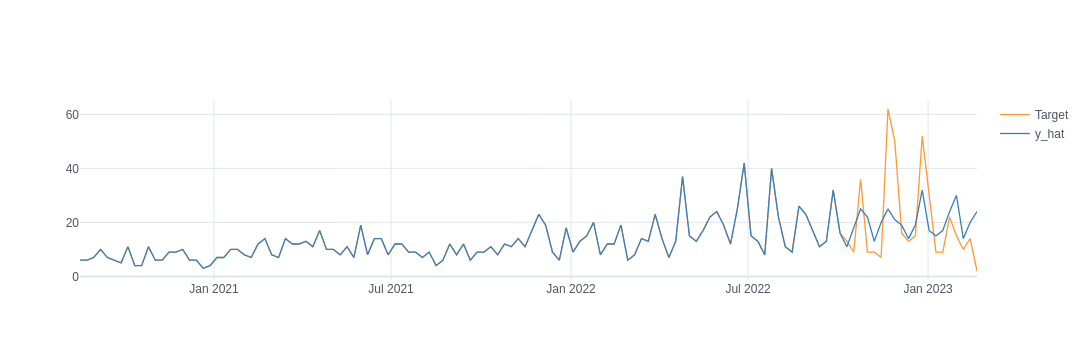

RMSE zone 4 delito 102: 14.492857278776613


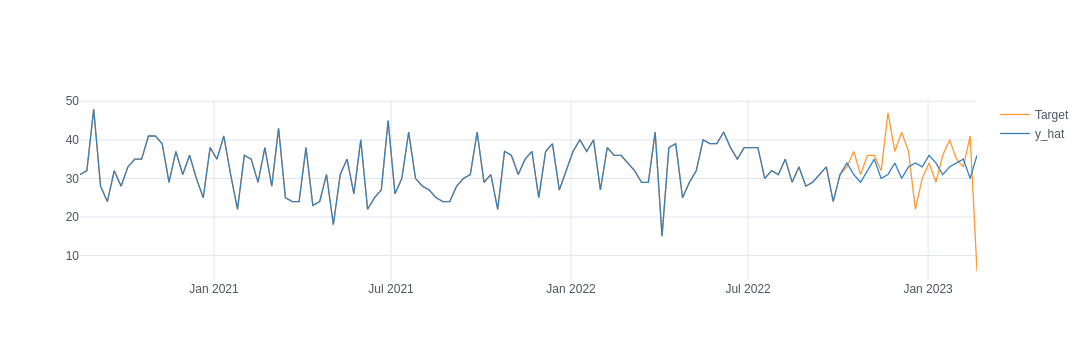

RMSE zone 4 delito 103: 9.338669531867389


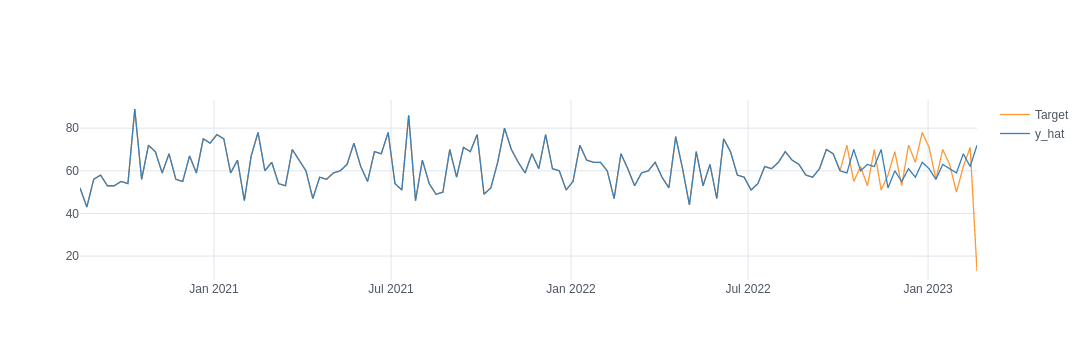

RMSE zone 4 delito 104: 16.132686007551893


In [96]:
for zone in range(5):
    for crime in range(100,105):
        column= "Crimes_Z"+str(zone)+"T"+str(crime)
        df= dc[column].copy()
        X_train, X_test, y_train, y_test = train_test_split(df.drop(['date','Target'],axis=1).to_numpy(),df[['Target']].to_numpy(), shuffle=False,test_size=.15)
        sc = MinMaxScaler()
        sc2 = MinMaxScaler()
        sc.fit(X_train)
        sc2.fit(y_train)
        pd.to_pickle(sc,'NewModels/Semana/sc_x_'+str(zone)+'_'+str(crime)+'.pkl')
        pd.to_pickle(sc2,'NewModels/Semana/sc_y_'+str(zone)+'_'+str(crime)+'.pkl')
        X_train, X_test = [sc.transform(x) for x in [X_train, X_test]]
        y_train, y_test= sc2.transform(y_train),sc2.transform(y_test)
        X_train = X_train.reshape(-1,X_train.shape[1])
        X_test = X_test.reshape(-1,X_test.shape[1])
        
        model = XGBRegressor()
        model.fit(X_train, y_train)
        
        df["y_hat"] = sc2.inverse_transform(model.predict(sc.transform(df.drop(['date','Target'],axis=1).to_numpy())).reshape(-1,1)).round(0) 
        temp2=df[["date",'Target','y_hat']]
        temp2.set_index("date").iplot()
        
        y_pred = sc2.inverse_transform((model.predict(X_test)).reshape(-1,1))
        
        rmse = np.sqrt(mean_squared_error(sc2.inverse_transform(y_test.reshape(-1,1)), y_pred))
        print(f'RMSE zone {str(zone)} delito {str(crime)}: {rmse}')
        
        with open('NewModels/XGBoost/modeloSem_'+str(zone)+'_'+str(crime)+'.pkl', 'wb') as file:
            pickle.dump(model, file)

### Preprocessing

In [66]:
df= data.copy()

In [67]:
column= 'Crimes_Z4T100'

In [68]:
zone=column[8]
crime=column[10:]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['date','Target'],axis=1).to_numpy(),df[['Target']].to_numpy(), shuffle=False)
sc = MinMaxScaler()
sc2 = MinMaxScaler()

In [70]:
sc.fit(X_train)
sc2.fit(y_train)
pd.to_pickle(sc,'NewModels/Semana/sc_x_'+str(zone)+'_'+str(crime)+'.pkl')
pd.to_pickle(sc2,'NewModels/Semana/sc_y_'+str(zone)+'_'+str(crime)+'.pkl')
X_train, X_test = [sc.transform(x) for x in [X_train, X_test]]
y_train, y_test= sc2.transform(y_train),sc2.transform(y_test)
X_train = X_train.reshape(-1,X_train.shape[1])
X_test = X_test.reshape(-1,X_test.shape[1])

In [71]:
X_train.shape

(99, 39)

### Model

In [72]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [73]:
y_pred = sc2.inverse_transform((model.predict(X_test)).reshape(-1,1))

In [74]:
df["y_hat"] = sc2.inverse_transform(model.predict(sc.transform(df.drop(['date','Target'],axis=1).to_numpy())).reshape(-1,1)).round(0) 

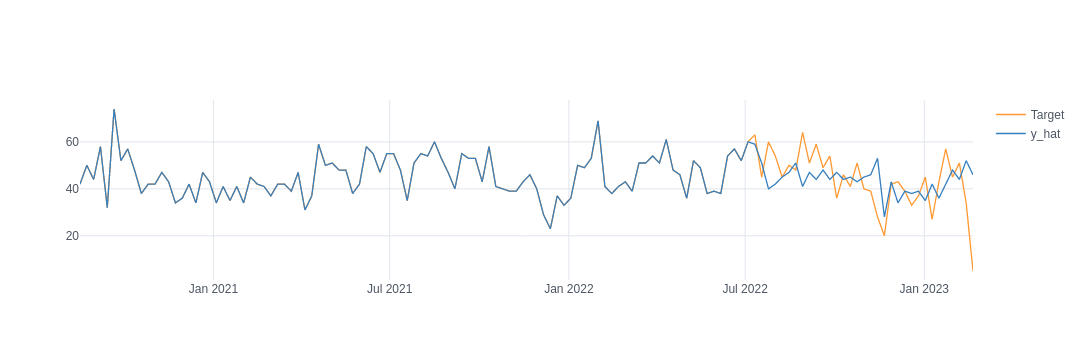

In [75]:
temp2=df[["date",'Target','y_hat']]
temp2.set_index("date").iplot()

In [77]:
rmse = np.sqrt(mean_squared_error(sc2.inverse_transform(y_test.reshape(-1,1)), y_pred))
print(f'RMSE: {rmse}')

RMSE: 12.544181695577292


In [76]:
with open('NewModels/XGBoost/modeloSem_'+zone+'_'+crime+'.pkl', 'wb') as file:
    pickle.dump(model, file)

In [78]:
df[["date","Target","y_hat"]].iloc[-33:]

,date,Target,y_hat
99,2022-07-11,63.0,59.0
100,2022-07-18,45.0,51.0
101,2022-07-25,60.0,40.0
102,2022-08-01,54.0,42.0
103,2022-08-08,45.0,45.0
104,2022-08-15,50.0,47.0
105,2022-08-22,48.0,51.0
106,2022-08-29,64.0,41.0
107,2022-09-05,51.0,47.0
108,2022-09-12,59.0,44.0
